<a href="https://colab.research.google.com/github/cisirtraining/summerschool/blob/master/resnet50_mias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Mount Google Drive for Data Access**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install git+https://github.com/raghakot/keras-vis.git
!pip install scipy==1.1.0
!pip install scikit-plot

##**Import Packages**

In [0]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import sklearn
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

##**Load Dataset**


*   Load images stored in data.npy and associated labels stored in data_label.npy
*   Label convention: Normal = 0 and Abnormal =1



In [0]:
# load dataset

X = np.load('./drive/My Drive/data/data.npy') # images
Y = np.load('./drive/My Drive/data/data_labels.npy') # labels associated to images (0 = normal, 1 = abnormal)
print('\n**** data loaded ****')

##**Dataset Statistic and Sanity Check**

In [0]:
#data statistic

def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of Normal Images: {}'.format(np.sum(b==0)))
    print('Number of Abnormal Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
    
describeData(X,Y)



In [0]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('normal')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('abnormal')
            plt.imshow(b[row+col])
            plt.axis('off')

imgs0 = X[Y==0] # (0 = normal, 1 = abnormal)
imgs1 = X[Y==1] 
            
plotTwo(imgs0, imgs1) 

In [0]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('abnormal' if Y[1] else 'normal')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X[100])

##**Data Preparation**


*   Split the data into training and testing set, 70% training and 30% testing
*   Convert labels to one-hot-encoded vectors 
*   Normalize the pixel between 0 and 1



In [0]:
random_state = 123
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,stratify=Y,random_state=random_state)


# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Training Data Shape:", X_train.shape, Y_train.shape)
print("Testing Data Shape:", X_test.shape, Y_test.shape)
print("\nLabel distribution:\nTraining >> {} \nTesting >> {}".format(collections.Counter(Y_train),collections.Counter(Y_test)))

# visualize normalize data
plotHistogram(X_train[100])

print('\nOriginal training label:\n',Y_train[0:5])

# Encode labels to hot vectors (ex : 2 -> 0=[1,0] and 1= [0,1])
from keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)


print('\nOne-hot encoded label:\n',Y_train[0:5])



##**Model Training**
>### Modified-ResNet50

connections from early layers to later layers through addition or straight up concatenation.

*   **Skip Connection/ Residual Connection** : Connections from early layers to later layers through addition or straight up concatenation -  it provides an alternative for gradient to back propagation and **avoid vanishing grdient problem as we go "deeper"**. This is better for model's convergences. At present, residual connection is a standard module in many convolutional network.

![](https://drive.google.com/uc?id=18Jy-BWPqrfX538tahaTbm1YOO8HtcOvO)

[Source](https://stackoverflow.com/questions/54207410/how-to-split-resnet50-model-from-top-as-well-as-from-bottom)

In [0]:
# define model 
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras.layers import Dense
from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten, Input, Lambda
from keras.layers import Add, Reshape, MaxPooling2D, Concatenate, Embedding, RepeatVector
from keras.applications.imagenet_utils import preprocess_input
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator



#Set Random Seed For Reproducibility
np.random.seed(40) # numpy random seed
tf.set_random_seed(89) # tensorflow random seed


model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
last_layer = model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)
# add fully-connected & dropout layers
x = Dense(2048, activation='relu', name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='fc-2')(x)
x = Dropout(0.5)(x)
# a softmax layer for 2 classes
out = Dense(2, activation='softmax', name='output_layer')(x)

# this is the model we will train
custom_resnet_model = Model(inputs=model.input, outputs=out)
custom_resnet_model.summary()

for layer in custom_resnet_model.layers:
    layer.trainable = True

opt = optimizers.SGD(lr = 0.0001, decay=1e-6, momentum=0.9, nesterov=True)
custom_resnet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  
checkpoint = ModelCheckpoint('./drive/My Drive/data/resnet50_mias.h5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True)


callbacks = [checkpoint]
t = time.time()
    

#training phase:

# history = custom_resnet_model.fit(X_train, Y_train, 
#                     batch_size=32, 
#                     epochs=100, 
#                     verbose=1, 
#                     validation_data=(X_test, Y_test),
#                     shuffle=True)

# custom_resnet_model.save('./drive/My Drive/mammogram/output/resnet50_miasv3.h5')
   
# print('Training time: %s' % (time.time() - t))

##**Plot Learning Curve**

Should have something like this!

![](https://drive.google.com/uc?id=1XTe9JRaWbIMPYrVC_FAWN2lbJKmb5CfL)

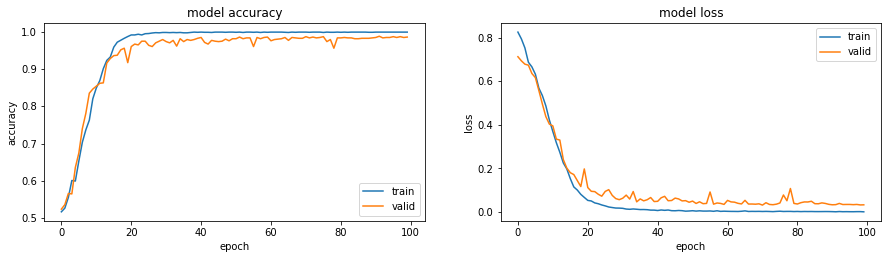

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'],loc='lower right') 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid'], loc='upper right') 

plt.show()

print(history.history.keys())

In [0]:
# Look at confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##**Standard Evaluation Metrics**



$$Precision = \frac{TP}{TP+FP} $$

$$Recall = \frac{TP}{TP+FN} $$

$$F1 = 2 * \frac{Precision*Recall}{Precision + Recall}$$



In [0]:
import itertools
from sklearn.metrics import confusion_matrix
from keras.models import load_model, Model
import scikitplot

# del model

# Load trained network
model = load_model('./drive/My Drive/data/resnet50_mias.h5')

print('\n\n************* model loaded *************')
score = model.evaluate(X_test, Y_test, verbose=0)
print("\n[info] loss={:.3f}, accuracy: {:.3f}%\n".format(score[0],score[1] * 100))
    
y_pred = model.predict(X_test) 
map_characters = {0: 'normal', 1: 'abnormal'}

print('\n', sklearn.metrics.classification_report(np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(Y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))

# Plot roc curve:
scikitplot.metrics.plot_roc(np.argmax(Y_test, axis=1), y_pred, figsize=(8,6))
plt.show()



In [0]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from google.colab.patches import cv2_imshow
import random


idx = random.sample(range(0, 900), 5) # regenerate random index
f, ax = plt.subplots(1, 5,figsize=(20,20))  

for i in range(5):
  
  # classify the input image
  (normal, abnormal) = model.predict(X_test)[idx[i]]
  label = "NORMAL" if normal > abnormal else "ABNORMAL"
  proba = abnormal if abnormal > normal else normal
  label = "{}: {:.2f}%".format(label, proba * 100)
  
  image = (X_test[idx[i]] * 255).round().astype(np.uint8)
  cv2.putText(image, label, (5, 15),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 1, cv2.LINE_AA)  
  
  ax[i].set_title('NORMAL' if (Y_test[idx[i]] == 1)[0] else 'ABNORMAL')
  ax[i].imshow(image)
  ax[i].set_axis_off()
         
 

##**CNN Interpretability: Saliency Map and GradCAM**



**Saliency Map:** In essence, saliency is what “stands out” in a photo or scene, enabling your eye-brain connection to quickly (and essentially unconsciously) focus on the most important regions. The idea behind saliency is pretty simple in hindsight. We compute the gradient of output category with respect to input image.This should tell us how the output value changes with respect to a small change in inputs. We can use these gradients to highlight input regions that cause the most change in the output. Intuitively this should highlight salient image regions that most contribute towards the output.


$$\frac{\partial output}{\partial input}$$


**GradCAM:** Gradient-weighted Class Activation Mapping (Grad-CAM), uses the class-specific gradient information flowing into the final convolutional layer of a CNN to produce a coarse localization map of the important regions in the image. Grad-CAM is a strict generalization of the Class Activation Mapping. Unlike CAM, Grad-CAM requires no re-training and is broadly applicable to any CNN-based architectures. Class activation maps or grad-CAM is another way of visualizing attention over input. Instead of using gradients with respect to output (see saliency), grad-CAM uses penultimate (pre Dense layer) Conv layer output. The intuition is to use the nearest Conv layer to utilize spatial information that gets completely lost in Dense layers.

 <figure>
<center>
<img src='https://drive.google.com/uc?id=1RpZ5jXgWxdoNQPfpCdNboMdXqkINusq9' />
</center>
</figure>

[Source](http://gradcam.cloudcv.org/)



##**Saliency Map: Normal Class**

In [0]:
# Visualize Saliency Map

from keras.models import load_model, Model
import numpy as np
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from random import randint
from matplotlib import gridspec

# Load trained network
#model = load_model('./drive/My Drive/data/resnet50_mias.h5')

layer_idx = utils.find_layer_idx(model, 'output_layer')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

class_idx = 0 # 0 = normal and 1 = abnormal
indices = np.where(Y_test[:, class_idx] == 1)[0] # first element of onehot-vector [0,1] or [1,0]

for i in range(3):
  
    value = randint(0,450)
    idx = indices[value]
    
    grads_vanilla = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_test[idx])
    grads_guided = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_test[idx],backprop_modifier='guided')

    plt.figure(figsize=(15,15))
    grid_spec = gridspec.GridSpec(1,4, width_ratios=[10,10,10,10])
    plt.subplot(grid_spec[0])
    plt.imshow(X_test[idx])
    plt.axis('off')
    plt.title('normal')
    
    plt.subplot(grid_spec[1])
    plt.imshow(X_test[idx][...,0])
    plt.axis('off')
    
    
    plt.subplot(grid_spec[2])
    plt.imshow(grads_vanilla, cmap='jet')
    plt.title('vanilla')
    plt.axis('off')
    
    plt.subplot(grid_spec[3])
    plt.imshow(grads_guided, cmap='jet')
    plt.title('guided')
    plt.axis('off')
  


##**Saliency Map: Abnormal Class**

In [0]:
class_idx = 1 # 0 = normal and 1 = abnormal
indices = np.where(Y_test[:, class_idx] == 1)[0] # first element of onehot-vector [0,1] or [1,0]

for i in range(3):
  
    value = randint(0,450)
    idx = indices[value]
    
    grads_vanilla = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_test[idx])
    grads_guided = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_test[idx],backprop_modifier='guided')

    plt.figure(figsize=(15,15))
    grid_spec = gridspec.GridSpec(1,4, width_ratios=[10,10,10,10])
    plt.subplot(grid_spec[0])
    plt.imshow(X_test[idx])
    plt.axis('off')
    plt.title('abnormal')
    
    plt.subplot(grid_spec[1])
    plt.imshow(X_test[idx][...,0])
    plt.axis('off')
    
    
    plt.subplot(grid_spec[2])
    plt.imshow(grads_vanilla, cmap='jet')
    plt.title('vanilla')
    plt.axis('off')
    
    plt.subplot(grid_spec[3])
    plt.imshow(grads_guided, cmap='jet')
    plt.title('guided')
    plt.axis('off')
  
    

##**GradCAM Visualization: Normal vs Abnormal**

 Example output from Gradient Class Activation Mapping (Grad-CAM)

![](https://drive.google.com/uc?id=1QG6MsQhNbrlelQbROycOADKNYMCw2tAB)

In [0]:
# Visualize Grad-CAM

from vis.visualization import visualize_cam
import matplotlib.cm as cm
from vis.visualization import overlay

penultimate_layer = utils.find_layer_idx(model, 'res5c_branch2c')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

for class_idx in np.arange(2):    
    indices = np.where(Y_test[:, class_idx] == 1)[0] # first element of onehot-vector [0,1] or [1,0]
    value = randint(0,450)
    idx = indices[value]
    
    f, ax = plt.subplots(1, 4,figsize=(15,15))
    ax[0].imshow(X_test[idx][...,0],cmap='gray')
    ax[0].set_title('normal' if class_idx==0 else 'abnormal')
    ax[0].set_axis_off()
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx,seed_input=X_test[idx], penultimate_layer_idx=penultimate_layer, backprop_modifier=modifier) 

        if modifier is None:
            modifier = 'vanilla'
            
        
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads,cmap='jet')
        ax[i+1].set_axis_off()
        